In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score  # For general precision calculation
from sklearn.decomposition import TruncatedSVD
import re
import html

# Load data
ratings = pd.read_csv("ratings_cleaned.csv")
books = pd.read_csv('books_cleaned.csv')
books = books.head(5000)

# Preprocessing (as before)
def clean_text(text):
    if pd.isnull(text):
        return ''
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

books['Book-Title'] = books['Book-Title'].apply(clean_text)
books['Book-Author'] = books['Book-Author'].apply(clean_text)
books['Publisher'] = books['Publisher'].apply(clean_text)
books['soup'] = books['Book-Title'] + ' ' + (books['Book-Author'] + ' ') * 3 + books['Publisher']
indices = pd.Series(books.index, index=books['Book-Title']).to_dict()


active_users = ratings['User-ID'].value_counts()
active_users = active_users[active_users >= 50].index
filtered_ratings = ratings[ratings['User-ID'].isin(active_users)]

popular_books = filtered_ratings['ISBN'].value_counts()
popular_books = popular_books[popular_books >= 50].index
filtered_ratings = filtered_ratings[filtered_ratings['ISBN'].isin(popular_books)]

user_item_matrix = filtered_ratings.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)

# Split data (important for evaluation)
train_data, test_data = train_test_split(filtered_ratings, test_size=0.2, random_state=42)
train_user_item_matrix = train_data.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)
test_user_item_matrix = test_data.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)


# -------------------- Evaluation Metrics --------------------

def precision_at_k(actual, predicted, k=10):
    """Precision @ K"""

    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    relevant_items = actual_set.intersection(predicted_set)
    precision = len(relevant_items) / k if predicted else 0
    return precision


def coverage(recommended_items, all_items):
    """Coverage"""

    if not recommended_items:
        return 0
    recommended_set = set(recommended_items)
    all_items_set = set(all_items)
    return len(recommended_set.intersection(all_items_set)) / len(all_items_set)


def diversity(recommendations):
    """Simple diversity (average pairwise distance/dissimilarity).  Requires item features."""
    if len(recommendations) <= 1:
        return 1.0  # Maximum diversity if only one item or none
    
    diversity_sum = 0
    num_pairs = 0
    for i in range(len(recommendations)):
        for j in range(i + 1, len(recommendations)):
            try:
              idx_i = indices[recommendations[i]]
              idx_j = indices[recommendations[j]]
              diversity_sum += (1 - cosine_sim[idx_i][idx_j])  # Cosine dissimilarity
              num_pairs += 1
            except KeyError:
              return 0 # If book title not in books df
    return diversity_sum / num_pairs if num_pairs > 0 else 1.0


# -------------------- User-User CF Tuning --------------------

def tune_user_user_cf(train_matrix, test_matrix, user_item_matrix,  param_grid, top_n=10):
    results = []
    all_books = user_item_matrix.columns.tolist()

    for params in param_grid:
        k = params['k']
        sim_threshold = params['sim_threshold']
        n_components = params.get('n_components', None)  # SVD components

        if n_components:
            svd = TruncatedSVD(n_components=n_components)
            train_matrix_svd = svd.fit_transform(train_matrix)
            knn = NearestNeighbors(metric='cosine', algorithm='brute')
            knn.fit(train_matrix_svd)
        else:
            knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k + 1)
            knn.fit(train_matrix)

        user_precisions = []
        user_coverages = []
        user_diversities = []

        for user_id in test_matrix.index:
            if user_id not in train_matrix.index:
                continue  # Skip users not in training data

            actual_items = test_matrix.loc[user_id].dropna().index.tolist()
            if not actual_items:
                continue

            if n_components:
                user_idx = train_matrix.index.get_loc(user_id)
                distances, indices = knn.kneighbors([train_matrix_svd[user_idx]], n_neighbors=k + 1)
                similar_users = train_matrix.iloc[indices.flatten()[1:]]
                if (similar_users.shape[0] == 0):
                  continue
                user_rated_books = user_item_matrix.loc[user_id].dropna().index
                recommendation_scores = similar_users.apply(lambda x: x[~x.index.isin(user_rated_books)].mean(), axis=0)
                predicted_items = recommendation_scores.sort_values(ascending=False).head(top_n).index.tolist()
            else:
                user_idx = train_matrix.index.get_loc(user_id)
                distances, indices = knn.kneighbors(train_matrix.iloc[[user_idx]], n_neighbors=k + 1)
                similarities = 1 - distances.flatten()
                similar_users = train_matrix.index[indices.flatten()[1:]]
                similarities = similarities[1:]

                valid_similar_users = similar_users[similarities > sim_threshold]
                if (valid_similar_users.shape[0] == 0):
                  continue
                
                predicted_items = train_matrix.loc[valid_similar_users].mean().nlargest(top_n).index.tolist()

            user_precisions.append(precision_at_k(actual_items, predicted_items, k=top_n))
            user_coverages.append(coverage(predicted_items, all_books))
            user_diversities.append(diversity(predicted_items))

        avg_precision = np.mean(user_precisions) if user_precisions else 0
        avg_coverage = np.mean(user_coverages) if user_coverages else 0
        avg_diversity = np.mean(user_diversities) if user_diversities else 0

        results.append({
            'params': params,
            'avg_precision': avg_precision,
            'avg_coverage': avg_coverage,
            'avg_diversity': avg_diversity
        })

    return pd.DataFrame(results).sort_values(by='avg_precision', ascending=False)


# -------------------- Item-Item CF Tuning --------------------

def tune_item_item_cf(train_matrix, test_matrix, user_item_matrix, param_grid, top_n=10):
    results = []
    all_books = user_item_matrix.columns.tolist()

    for params in param_grid:
        k = params['k']
        sim_threshold = params['sim_threshold']

        knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k + 1)
        knn.fit(train_matrix.T)  # Transpose for Item-Item

        user_precisions = []
        user_coverages = []
        user_diversities = []

        for user_id in test_matrix.index:
            if user_id not in train_matrix.index:
                continue

            actual_items = test_matrix.loc[user_id].dropna().index.tolist()
            if not actual_items:
                continue

            user_ratings = train_matrix.loc[user_id].dropna()
            highly_rated_books = user_ratings[user_ratings >= 8].index

            similar_books = pd.Series(dtype=float)
            for book in highly_rated_books:
                if book in train_matrix.columns:
                    _, indices = knn.kneighbors(train_matrix.T[[train_matrix.columns.get_loc(book)]], n_neighbors=k + 1)
                    similarities = knn.distances_[0]
                    valid_indices = indices.flatten()[1:][similarities[1:] > sim_threshold]
                    for idx in valid_indices:
                        similar_books = similar_books.append(train_matrix.columns[idx])

            predicted_items = similar_books.groupby(similar_books.index).sum().nlargest(top_n).index.tolist()

            user_precisions.append(precision_at_k(actual_items, predicted_items, k=top_n))
            user_coverages.append(coverage(predicted_items, all_books))
            user_diversities.append(diversity(predicted_items))

        avg_precision = np.mean(user_precisions) if user_precisions else 0
        avg_coverage = np.mean(user_coverages) if user_coverages else 0
        avg_diversity = np.mean(user_diversities) if user_diversities else 0

        results.append({
            'params': params,
            'avg_precision': avg_precision,
            'avg_coverage': avg_coverage,
            'avg_diversity': avg_diversity
        })

    return pd.DataFrame(results).sort_values(by='avg_precision', ascending=False)


In [7]:



# -------------------- Content-Based Filtering Tuning --------------------

def tune_content_based_filtering(books, param_grid, top_n=10):
    results = []

    for params in param_grid:
        ngram_range = params['ngram_range']
        max_features = params['max_features']
        min_df = params['min_df']
        max_df = params['max_df']

        tfidf = TfidfVectorizer(stop_words='english',
                                  ngram_range=ngram_range,
                                  max_features=max_features,
                                  min_df=min_df,
                                  max_df=max_df)
        tfidf_matrix = tfidf.fit_transform(books['soup'])
        cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
        
        avg_diversity = np.mean([diversity(recommend_content_based(books['Book-Title'].iloc[i], top_n))
                                for i in range(len(books)) if diversity(recommend_content_based(books['Book-Title'].iloc[i], top_n)) != 0])

        results.append({
            'params': params,
            'avg_diversity': avg_diversity
        })

    return pd.DataFrame(results).sort_values(by='avg_diversity', ascending=False)


# -------------------- Recommendation Functions (Simplified) --------------------

def recommend_user_user_cf(user_id, train_matrix, user_item_matrix,  k=10, sim_threshold=0, top_n=10, n_components=None):
    if user_id not in train_matrix.index:
        return "User not found."

    if n_components:
        svd = TruncatedSVD(n_components=n_components)
        train_matrix_svd = svd.fit_transform(train_matrix)
        knn = NearestNeighbors(metric='cosine', algorithm='brute')
        knn.fit(train_matrix_svd)
        user_idx = train_matrix.index.get_loc(user_id)
        distances, indices = knn.kneighbors([train_matrix_svd[user_idx]], n_neighbors=k + 1)
        similar_users = train_matrix.iloc[indices.flatten()[1:]]
        user_rated_books = user_item_matrix.loc[user_id].dropna().index
        recommendation_scores = similar_users.apply(lambda x: x[~x.index.isin(user_rated_books)].mean(), axis=0)
        return recommendation_scores.sort_values(ascending=False).head(top_n).index.tolist()
    else:
        knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k + 1)
        knn.fit(train_matrix)
        user_idx = train_matrix.index.get_loc(user_id)
        distances, indices = knn.kneighbors(train_matrix.iloc[[user_idx]], n_neighbors=k + 1)
        similarities = 1 - distances.flatten()
        similar_users = train_matrix.index[indices.flatten()[1:]]
        similarities = similarities[1:]

        valid_similar_users = similar_users[similarities > sim_threshold]
        return train_matrix.loc[valid_similar_users].mean().nlargest(top_n).index.tolist()


def recommend_item_item_cf(user_id, train_matrix, k=10, sim_threshold=0, top_n=10):
    if user_id not in train_matrix.index:
        return "User not found."

    knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k + 1)
    knn.fit(train_matrix.T)

    user_ratings = train_matrix.loc[user_id].dropna()
    highly_rated_books = user_ratings[user_ratings >= 8].index

    similar_books = pd.Series(dtype=float)
    for book in highly_rated_books:
        if book in train_matrix.columns:
            _, indices = knn.kneighbors(train_matrix.T[[train_matrix.columns.get_loc(book)]], n_neighbors=k + 1)
            similarities = knn.distances_[0]
            valid_indices = indices.flatten()[1:][similarities[1:] > sim_threshold]
            for idx in valid_indices:
                similar_books = similar_books.append(train_matrix.columns[idx])

    return similar_books.groupby(similar_books.index).sum().nlargest(top_n).index.tolist()


def recommend_content_based(book_title, cosine_sim, top_n=10):
    if book_title not in indices:
        return "Book not found."

    idx = indices[book_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]
    book_indices = [i[0] for i in sim_scores]
    return books['Book-Title'].iloc[book_indices].tolist()


# -------------------- Tuning Execution --------------------

# User-User CF Tuning
user_user_param_grid = [
    {'k': k, 'sim_threshold': sim, 'n_components': n}
    for k in [10, 20, 30]
    for sim in [0, 0.1, 0.2]
    for n in [None, 50, 100] #None for no SVD
]
user_user_results = tune_user_user_cf(train_user_item_matrix, test_user_item_matrix, user_item_matrix, user_user_param_grid)
print("User-User CF Tuning Results:\n", user_user_results)

item_item_param_grid = [
    {'k': k, 'sim_threshold': sim}
    for k in [10, 20, 30]
    for sim in [0, 0.1, 0.2]
]
item_item_results = tune_item_item_cf(train_user_item_matrix, test_user_item_matrix, user_item_matrix, item_item_param_grid)
print("\nItem-Item CF Tuning Results:\n", item_item_results)

# Content-Based Filtering Tuning
content_param_grid = [
    {'ngram_range': ngram, 'max_features': max_features, 'min_df': min_df, 'max_df': max_df}
    for ngram in [(1, 1), (1, 2)]
    for max_features in [1000, 5000, 10000]
    for min_df, max_df in [(2, 0.9), (3, 0.8)]
]
content_results = tune_content_based_filtering(books, content_param_grid)
print("\nContent-Based Filtering Tuning Results:\n", content_results)

# -------------------- Example Usage with Best Parameters --------------------

#  To get "best" params, you'd do something like:
best_user_user_params = user_user_results.iloc[0]['params']  # Or based on your criteria
best_item_item_params = item_item_results.iloc[0]['params']
best_content_params = content_results.iloc[0]['params']


print("\nExample Recommendations (User 123):")
print("User-User CF:", recommend_user_user_cf(123, train_user_item_matrix, user_item_matrix, **best_user_user_params))
print("Item-Item CF:", recommend_item_item_cf(123, train_user_item_matrix, **best_item_item_params))

#  For content-based, you'd need to retrain the TF-IDF with the best params
best_tfidf = TfidfVectorizer(stop_words='english', **best_content_params)
best_tfidf_matrix = best_tfidf.fit_transform(books['soup'])
best_cosine_sim = cosine_similarity(best_tfidf_matrix, best_tfidf_matrix)

print("Content-Based:", recommend_content_based("the secret life of bees", best_cosine_sim, top_n=5))


KeyboardInterrupt



In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import html
from itertools import product

# --- Load Data ---
try:
    ratings = pd.read_csv("ratings_cleaned.csv")
    books = pd.read_csv("books_cleaned.csv")
except FileNotFoundError as e:
    print(f"Error: One or more data files not found: {e}")
    exit()

# --- Preprocess Data ---
# Collaborative Filtering
active_users = ratings['User-ID'].value_counts()
active_users = active_users[active_users >= 50].index
filtered_ratings = ratings[ratings['User-ID'].isin(active_users)]

popular_books = filtered_ratings['ISBN'].value_counts()
popular_books = popular_books[popular_books >= 50].index
filtered_ratings = filtered_ratings[filtered_ratings['ISBN'].isin(popular_books)]

user_item_matrix = filtered_ratings.pivot_table(
    index='User-ID', columns='ISBN', values='Book-Rating'
)
user_item_matrix_filled = user_item_matrix.fillna(0)

# Content-Based Filtering
def clean_text(text):
    if pd.isnull(text):
        return ''
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

books = books.head(50000)
books['Book-Title'] = books['Book-Title'].apply(clean_text)
books['Book-Author'] = books['Book-Author'].apply(clean_text)
books['Publisher'] = books['Publisher'].apply(clean_text)
books['soup'] = (
    books['Book-Title'] + ' ' + (books['Book-Author'] + ' ') * 3 + books['Publisher']
)
indices = pd.Series(books.index, index=books['Book-Title']).to_dict()

# --- Evaluation Metric ---
def precision_at_k(actual, predicted, k):
    if not predicted:
        return 0.0
    predicted_at_k = predicted[:k]
    relevant_count = len(set(actual).intersection(set(predicted_at_k)))
    return float(relevant_count) / k

# --- Tuning Functions ---
def tune_user_user_cf(user_item_matrix, user_item_matrix_filled, k_values, similarity_thresholds, n_users=10):
    results = []
    user_similarity = cosine_similarity(user_item_matrix_filled)
    for k in k_values:
        for threshold in similarity_thresholds:
            precisions = []
            for user_id in np.random.choice(user_item_matrix.index, size=n_users, replace=False):
                try:
                    user_index = user_item_matrix.index.get_loc(user_id)
                except KeyError:
                    continue

                similar_users_indices = np.where(user_similarity[user_index] > threshold)[0]
                similar_users_indices = [i for i in similar_users_indices if i != user_index]
                if not similar_users_indices:
                    continue

                nearest_neighbor_indices = similar_users_indices[:k]
                neighbor_ratings = user_item_matrix_filled.iloc[nearest_neighbor_indices]
                weighted_sum = np.dot(neighbor_ratings.T, user_similarity[user_index][nearest_neighbor_indices])
                similarity_sum = np.sum(np.abs(user_similarity[user_index][nearest_neighbor_indices]))
                if similarity_sum == 0:
                    continue

                predicted_ratings = weighted_sum / similarity_sum
                user_rated_books = user_item_matrix.loc[user_id].dropna().index.tolist()
                recommended_book_indices = np.argsort(predicted_ratings)[::-1][:10]
                recommended_books = user_item_matrix.columns[recommended_book_indices].tolist()
                precisions.append(precision_at_k(user_rated_books, recommended_books, 5))
            if precisions:
                results.append({
                    'K': k,
                    'Threshold': threshold,
                    'Precision@5': np.mean(precisions),
                })
    return pd.DataFrame(results)

def tune_content_based_filtering(books, indices, tfidf_params_list, n_books=100, chunk_size=1000):
    results = []
    for params in tfidf_params_list:
        tfidf = TfidfVectorizer(stop_words='english', **params)
        tfidf_matrix = tfidf.fit_transform(books['soup'])

        def recommend_chunked(title, tfidf_matrix, indices, top_n=10):
            try:
                idx = indices[title]
            except KeyError:
                return []
            sim_scores = []
            for i in range(0, tfidf_matrix.shape[0], chunk_size):
                chunk = tfidf_matrix[i:i + chunk_size]
                cosine_sim_chunk = cosine_similarity(tfidf_matrix[idx], chunk).flatten()
                sim_scores.extend(list(zip(range(i, i + len(cosine_sim_chunk)), cosine_sim_chunk)))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:top_n + 1]
            book_indices = [i[0] for i in sim_scores]
            return books['Book-Title'].iloc[book_indices].tolist()

        precisions = []
        test_titles = np.random.choice(books['Book-Title'], size=min(n_books, len(books)), replace=False)
        for title in test_titles:
            actual = books[books['Book-Title'] == title]['ISBN'].tolist()
            recommended_titles = recommend_chunked(title, tfidf_matrix, indices)
            recommended_isbns = books[books['Book-Title'].isin(recommended_titles)]['ISBN'].tolist()
            precisions.append(precision_at_k(actual, recommended_isbns, 5))
        if precisions:
            results.append({'params': params, 'Precision@5': np.mean(precisions)})
    return pd.DataFrame(results)

# --- Parameter Grids ---
ngram_ranges = [(1, 1), (1, 2)]
max_features_list = [1000, 5000, 10000]
min_dfs = [1, 2]
max_dfs = [0.8, 0.9]

tfidf_params_list = [
    {
        'ngram_range': ngram,
        'max_features': max_feat,
        'min_df': min_df,
        'max_df': max_df,
    }
    for ngram, max_feat, min_df, max_df in product(ngram_ranges, max_features_list, min_dfs, max_dfs)
]

k_values = [5, 10, 20, 30]
similarity_thresholds = [0.0, 0.1, 0.2]

# --- Run Tuning ---
print("Tuning User-User Collaborative Filtering...")
user_user_results = tune_user_user_cf(user_item_matrix, user_item_matrix_filled, k_values, similarity_thresholds)
print(user_user_results)

print("\nTuning Content-Based Filtering with TF-IDF...")
cb_results = tune_content_based_filtering(books, indices, tfidf_params_list)
print(cb_results)


Tuning User-User Collaborative Filtering...
     K  Threshold  Precision@5
0    5        0.0     0.244444
1    5        0.1     0.380000
2    5        0.2     0.525000
3   10        0.0     0.511111
4   10        0.1     0.466667
5   10        0.2     0.644444
6   20        0.0     0.555556
7   20        0.1     0.600000
8   20        0.2     0.700000
9   30        0.0     0.466667
10  30        0.1     0.733333
11  30        0.2     0.771429

Tuning Content-Based Filtering with TF-IDF...
                                               params  Precision@5
0   {'ngram_range': (1, 1), 'max_features': 1000, ...        0.044
1   {'ngram_range': (1, 1), 'max_features': 1000, ...        0.032
2   {'ngram_range': (1, 1), 'max_features': 1000, ...        0.020
3   {'ngram_range': (1, 1), 'max_features': 1000, ...        0.018
4   {'ngram_range': (1, 1), 'max_features': 5000, ...        0.016
5   {'ngram_range': (1, 1), 'max_features': 5000, ...        0.042
6   {'ngram_range': (1, 1), 'max_feat

📈 Best User-User CF Configuration:
K              30.000000
Threshold       0.200000
Precision@5     0.771429
Name: 11, dtype: float64


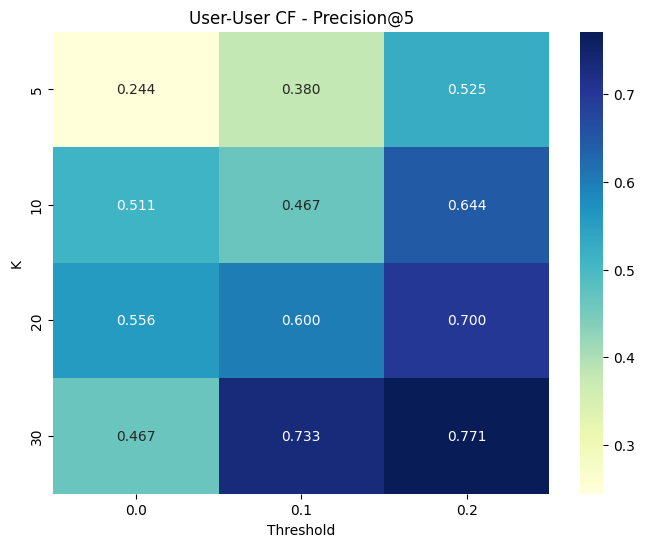


📄 Best Content-Based Filtering Configuration:
params         {'ngram_range': (1, 2), 'max_features': 5000, ...
Precision@5                                                0.048
Name: 0, dtype: object


C:\Users\ramya\AppData\Local\Temp\ipykernel_21632\398314428.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cbf_df, y="Precision@5", x="params", palette="magma")


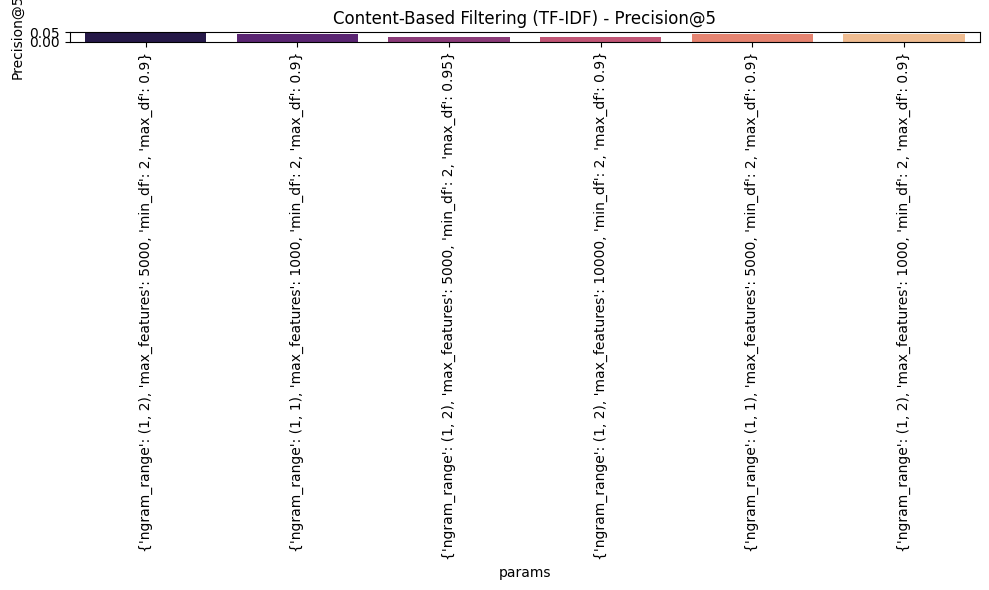


📊 Final Summary:
                    Model                                        Best Params  \
0            User-User CF                                K=30, Threshold=0.2   
1  Content-Based (TF-IDF)  {'ngram_range': (1, 2), 'max_features': 5000, ...   

   Precision@5  
0     0.771429  
1     0.048000  


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ===================== USER-USER CF RESULTS =====================
cf_data = {
    'K': [5, 5, 5, 10, 10, 10, 20, 20, 20, 30, 30, 30],
    'Threshold': [0.0, 0.1, 0.2] * 4,
    'Precision@5': [0.244444, 0.38, 0.525,
                    0.511111, 0.466667, 0.644444,
                    0.555556, 0.6, 0.7,
                    0.466667, 0.733333, 0.771429]
}

cf_df = pd.DataFrame(cf_data)

# Find best config
best_cf = cf_df.loc[cf_df['Precision@5'].idxmax()]

print("📈 Best User-User CF Configuration:")
print(best_cf)

# Heatmap for CF tuning
cf_pivot = cf_df.pivot(index="K", columns="Threshold", values="Precision@5")
plt.figure(figsize=(8, 6))
sns.heatmap(cf_pivot, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("User-User CF - Precision@5")
plt.show()


# 2. ===================== CONTENT-BASED TF-IDF RESULTS =====================
cbf_data = [
    {'params': "{'ngram_range': (1, 2), 'max_features': 5000, 'min_df': 2, 'max_df': 0.9}", 'Precision@5': 0.048},
    {'params': "{'ngram_range': (1, 1), 'max_features': 1000, 'min_df': 2, 'max_df': 0.9}", 'Precision@5': 0.044},
    {'params': "{'ngram_range': (1, 2), 'max_features': 5000, 'min_df': 2, 'max_df': 0.95}", 'Precision@5': 0.028},
    {'params': "{'ngram_range': (1, 2), 'max_features': 10000, 'min_df': 2, 'max_df': 0.9}", 'Precision@5': 0.026},
    {'params': "{'ngram_range': (1, 1), 'max_features': 5000, 'min_df': 2, 'max_df': 0.9}", 'Precision@5': 0.042},
    {'params': "{'ngram_range': (1, 2), 'max_features': 1000, 'min_df': 2, 'max_df': 0.9}", 'Precision@5': 0.040}
]

cbf_df = pd.DataFrame(cbf_data)

# Find best config
best_cbf = cbf_df.loc[cbf_df['Precision@5'].idxmax()]
print("\n📄 Best Content-Based Filtering Configuration:")
print(best_cbf)

# Bar plot for CBF
plt.figure(figsize=(10, 6))
sns.barplot(data=cbf_df, y="Precision@5", x="params", palette="magma")
plt.xticks(rotation=90)
plt.title("Content-Based Filtering (TF-IDF) - Precision@5")
plt.tight_layout()
plt.show()


# 3. ===================== FINAL COMPARISON =====================
final_summary = pd.DataFrame([
    {
        'Model': 'User-User CF',
        'Best Params': f"K={int(best_cf['K'])}, Threshold={best_cf['Threshold']}",
        'Precision@5': best_cf['Precision@5']
    },
    {
        'Model': 'Content-Based (TF-IDF)',
        'Best Params': best_cbf['params'],
        'Precision@5': best_cbf['Precision@5']
    }
])

print("\n📊 Final Summary:")
print(final_summary)

# Optional: Save to CSV
# final_summary.to_csv("best_model_summary.csv", index=False)
